<a href="https://colab.research.google.com/github/mirazAL/TBFC_2021/blob/main/Transfer_learning_of_TBFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import glob,os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,Activation

In [ ]:
classes=os.listdir('/content/drive/MyDrive/Traditional Food Classification/set 1/train_noise_and_noise_rot15_flipv/')
classes

['কালা ভুনা',
 'পান্তা ইলিশ',
 'বিরিয়ানি',
 'খিচুড়ি',
 'ডিম ভুনা',
 'ফুচকা',
 'মিষ্টি,রসগোল্লা']

In [ ]:
import os

s='/content/drive/MyDrive/Traditional Food Classification/set 1/validation/'
c=0

for f in os.listdir(s):
  c+=len(os.listdir(s+f))
  print(f,len(os.listdir(s+f)))

print(c)

খিচুড়ি 43
কালা ভুনা 21
ডিম ভুনা 25
মিষ্টি,রসগোল্লা 36
পান্তা ইলিশ 18
বিরিয়ানি 35
ফুচকা 39
217


In [ ]:
# type(valid.labels)
import collections, numpy
collections.Counter(valid.labels)

Counter({0: 43, 1: 35, 2: 18, 3: 25, 4: 21, 5: 38, 6: 36})

In [ ]:
labels=['khichuri','Biriyani','Panta Ilish','Dim_Vuna','Kala_Vuna','Fuchka','Rosogolla']

In [ ]:
# train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     zoom_range=0.25,
#     horizontal_flip=True,
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     # shear_range=0.2
#     )

# val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     )

train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    # zoom_range=0.25,
    # horizontal_flip=True,
    # rotation_range=8,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    )

val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    )

In [ ]:
train_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/train_noise_and_noise_rot15_flipv/'
train=train_data_aug.flow_from_directory(directory=train_dir,
        target_size=(299, 299),
        batch_size=32,
        color_mode="rgb",
        shuffle=True,
        classes=classes,
        class_mode='categorical')

Found 2619 images belonging to 7 classes.


In [ ]:
valid_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/validation'
valid=val_data_aug.flow_from_directory(directory=valid_dir,
        target_size=(299, 299),
        # target_size=(224, 224),
        batch_size=36,
        color_mode="rgb",
        shuffle=False,
        classes=classes,
        class_mode='categorical')

Found 216 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
incpt = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
incpt.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
layers = [l for l in vgg.layers]
for i in range(len(layers)):
  print(i,layers[i])

In [ ]:
for layer in vgg.layers[:15]:
  layer.trainable = False
for layer in vgg.layers[15:]:
  layer.trainable = True
# do not train first layers, I want to only train
# the 4 last layers (my own choice, up to you)
# vgg.trainable = False

In [ ]:
model = Sequential()

# model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(incpt)
model.add(Flatten())
# # finalize with standard Dense, Dropout...
# model.add(Dense(256, activation='relu'))
# # model.add(BatchNormalization())
# model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 55,359,271
Trainable params: 55,324,839
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

model.compile(loss='categorical_crossentropy',
              # optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
model.optimizer,model.optimizer.learning_rate

(<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop at 0x7fba823c9650>,
 <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>)

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = '/content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc{val_accuracy:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1,callbacks=[checkpoint])

Epoch 1/100
82/82 [==============================] - 779s 9s/step - loss: 8.6980 - accuracy: 0.1578 - val_loss: 197071.9688 - val_accuracy: 0.1620

Epoch 00001: val_accuracy improved from -inf to 0.16204, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.162.h5
Epoch 2/100
82/82 [==============================] - 50s 601ms/step - loss: 2.5471 - accuracy: 0.1893 - val_loss: 80279.0547 - val_accuracy: 0.1667

Epoch 00002: val_accuracy improved from 0.16204 to 0.16667, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.167.h5
Epoch 3/100
82/82 [==============================] - 49s 597ms/step - loss: 2.3780 - accuracy: 0.1907 - val_loss: 1729.0634 - val_accuracy: 0.1759

Epoch 00003: val_accuracy improved from 0.16667 to 0.17593, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.176.h5
Epoch 4/100
82/82 [==============================] - 49s 

In [ ]:
max(history.history['val_accuracy']) 

0.9583333134651184

In [ ]:
model_json =model.to_json()
with open("/content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# model.save_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/incpt.h5")
# print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
json_file = open('/content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.847.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 21,139,283
Trainable params: 13,504,013
Non-trainable params: 7,635,270
____________________________________

In [ ]:
# y_true = np.array([np.where(label[0][i] == 1)[0][0] for i in range(216)])
# y_true.shape
y_true=valid.labels
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = loaded_model.predict_generator(valid, 6)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_pred_ = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]) 

In [ ]:
print('Confusion Matrix')
conf_mat=confusion_matrix(y_true, y_pred)
print(conf_mat)


Confusion Matrix
[[19  1  0  0  0  0  1]
 [ 1 10  2  0  1  4  0]
 [ 0  0 32  0  0  3  0]
 [ 0  0  7 36  0  0  0]
 [ 0  0  0  1 23  1  0]
 [ 0  7  1  1  0 29  0]
 [ 0  2  0  0  0  0 34]]


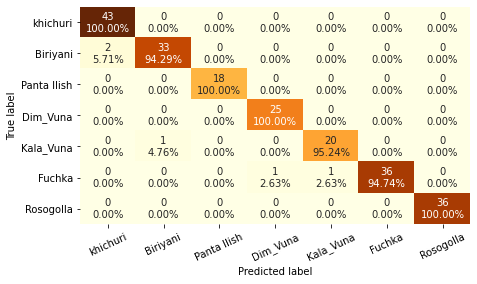

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,group_names=None,categories='auto', count=True,percent=True,cbar=True,xyticks=True,
                          xyplotlabels=True,sum_stats=True,figsize=None,cmap='Blues', accuracy=True,title=None):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        # group_percentages = ["{0:.2%}".format(value) for value in np.array([cf/np.sum(cf) for cf in cf]).flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in np.array([cnf/np.sum(cnf) for cnf in cf]).flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    if accuracy==True:
      if sum_stats:
          accuracy  = np.trace(cf) / float(np.sum(cf))

          if len(cf)==2:
              precision = cf[1,1] / sum(cf[:,1])
              recall    = cf[1,1] / sum(cf[1,:])
              f1_score  = 2*precision*recall / (precision + recall)
              stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                  accuracy,precision,recall,f1_score)
          else:
              stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
          stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.yticks(rotation=0)
        plt.xlabel('Predicted label' + stats_text)
        plt.xticks(rotation=25)
        plt.savefig('conf.jpeg',dpi=600)
    else:
        plt.xlabel(stats_text)
        plt.yticks(rotation=0)
        plt.xticks(rotation=25)
        plt.savefig('conf.jpeg',dpi=600)
    if title:
        plt.title(title)
        plt.yticks(rotation=0)
        plt.xticks(rotation=25)
        plt.savefig('conf.jpeg',dpi=600)

make_confusion_matrix(conf_mat, figsize=(7,4),percent=True,count=True,accuracy=False,
                      categories=['khichuri','Biriyani','Panta Ilish','Dim_Vuna','Kala_Vuna','Fuchka','Rosogolla'],
                      cbar=False,cmap='YlOrBr')


In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, 
    target_names=['Kala_Vuna','Panta_Ilish','Biriyani','Khichuri','Dim_Vuna','Fuchka','Rosogolla']))


Classification Report
              precision    recall  f1-score   support

   Kala_Vuna       0.95      0.90      0.93        21
 Panta_Ilish       0.50      0.56      0.53        18
    Biriyani       0.76      0.91      0.83        35
    Khichuri       0.95      0.84      0.89        43
    Dim_Vuna       0.96      0.92      0.94        25
      Fuchka       0.78      0.76      0.77        38
   Rosogolla       0.97      0.94      0.96        36

    accuracy                           0.85       216
   macro avg       0.84      0.83      0.83       216
weighted avg       0.86      0.85      0.85       216



In [ ]:
import pickle
with open('/content/drive/MyDrive/Traditional Food Classification/set 1/history_incpt', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [ ]:
model_json =model.to_json()
with open("/content/drive/MyDrive/Traditional Food Classification/set 1/incpt.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/incpt.h5")
print("Saved model to disk")

Saved model to disk


# Fine Tuned VGG16 (98% Accuracy)

## Classes

In [ ]:
classes=os.listdir('/content/drive/MyDrive/Traditional Food Classification/Traditional Food Classification/')
classes

['খিচুড়ি',
 'বিরিয়ানি',
 'পান্তা ইলিশ',
 'ডিম ভুনা',
 'কালা ভুনা',
 'ফুচকা',
 'মিষ্টি,রসগোল্লা']

In [ ]:
# type(valid.labels)
import collections, numpy
collections.Counter(valid.labels)

Counter({0: 43, 1: 35, 2: 18, 3: 25, 4: 21, 5: 38, 6: 36})

In [ ]:
labels=['Khichuri','Biriyani','Panta Ilish','Dim_Vuna','Kala_Vuna','Fuchka','Rosogolla']

## Preprocessing

In [ ]:
train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.25,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    )

val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )

### Train data

In [ ]:
train_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/train_noise_and_noise_rot15_flipv/'
train=train_data_aug.flow_from_directory(directory=train_dir,
        target_size=(224, 224),
        batch_size=32,
        color_mode="rgb",
        shuffle=True,
        classes=classes,
        class_mode='categorical')

Found 2619 images belonging to 7 classes.


### Test data

In [ ]:
valid_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/validation'
valid=val_data_aug.flow_from_directory(directory=valid_dir,
        # target_size=(299, 299),
        target_size=(224, 224),
        batch_size=36,
        color_mode="rgb",
        shuffle=False,
        classes=classes,
        class_mode='categorical')

Found 216 images belonging to 7 classes.


## Loading Pretrained VGG16 Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

In [ ]:
layers = [l for l in vgg.layers]
for i in range(len(layers)):
  print(i,layers[i])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f75438aded0>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7545194c50>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f75438117d0>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f75437f4d90>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f75438b2090>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7542b6c310>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7542b73e50>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7542b7ded0>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7542b7d450>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7542b82f90>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7542b8bf90>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7542b8dc90>
12 <tensorflow.python.ke

## Fine tune last Conv Block

In [ ]:
for layer in vgg.layers[:15]:
  layer.trainable = False
for layer in vgg.layers[15:]:
  layer.trainable = True

## Final Model

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(vgg)
model.add(Flatten())
# finalize with standard Dense, Dropout...
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 21,139,283
Trainable params: 13,504,013
Non-trainable params: 7,635,270
____________________________________

#### Compiling hyperparameters

In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

model.compile(loss='logcosh',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

## Model Training

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = '/content/drive/MyDrive/Traditional Food Classification/set 1/fine_Tuned_vgg16_val_acc{val_accuracy:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1,callbacks=[checkpoint])

Epoch 1/100
82/82 [==============================] - 92s 973ms/step - loss: 0.0479 - accuracy: 0.3806 - val_loss: 0.0286 - val_accuracy: 0.7037

Epoch 00001: val_accuracy improved from -inf to 0.70370, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/fine_Tuned_vgg16_val_acc0.704.h5
Epoch 2/100
82/82 [==============================] - 65s 796ms/step - loss: 0.0238 - accuracy: 0.7423 - val_loss: 0.0072 - val_accuracy: 0.9306

Epoch 00002: val_accuracy improved from 0.70370 to 0.93056, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/fine_Tuned_vgg16_val_acc0.931.h5
Epoch 3/100
82/82 [==============================] - 65s 793ms/step - loss: 0.0145 - accuracy: 0.8469 - val_loss: 0.0173 - val_accuracy: 0.8380

Epoch 00003: val_accuracy did not improve from 0.93056
Epoch 4/100
82/82 [==============================] - 64s 782ms/step - loss: 0.0151 - accuracy: 0.8505 - val_loss: 0.0079 - val_accuracy: 0.9167

Epoch 00004: val_accuracy di

## Loading the saved final model

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
json_file = open('/content/drive/MyDrive/Traditional Food Classification/set 1/vgg16.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/fine_Tuned_vgg16_val_acc0.972.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 21,139,283
Trainable params: 13,504,013
Non-trainable params: 7,635,270
____________________________________

## Predict labels of test data

In [ ]:
# y_true = np.array([np.where(label[0][i] == 1)[0][0] for i in range(216)])
# y_true.shape
y_true=valid.labels
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = loaded_model.predict_generator(valid, 6)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [ ]:
y_pred_ = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]) 

## Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
conf_mat=confusion_matrix(y_true, y_pred_)
print(conf_mat)

Confusion Matrix
[[43  0  0  0  0  0  0]
 [ 2 33  0  0  0  0  0]
 [ 0  0 18  0  0  0  0]
 [ 0  0  0 25  0  0  0]
 [ 0  1  0  0 20  0  0]
 [ 0  0  0  1  1 36  0]
 [ 0  0  0  0  0  0 36]]


In [ ]:
print('Confusion Matrix')
conf_mat=confusion_matrix(y_true, y_pred_)
print(conf_mat)

Confusion Matrix
[[43  0  0  0  0  0  0]
 [ 2 33  0  0  0  0  0]
 [ 0  0 18  0  0  0  0]
 [ 0  0  0 25  0  0  0]
 [ 0  1  0  0 20  0  0]
 [ 0  0  0  1  1 36  0]
 [ 0  0  0  0  0  0 36]]


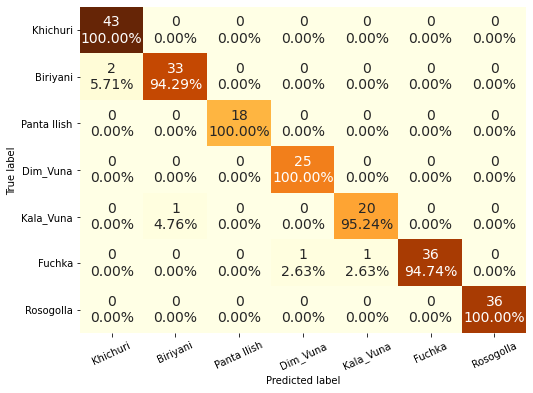

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,group_names=None,categories='auto', count=True,percent=True,cbar=True,xyticks=True,
                          xyplotlabels=True,sum_stats=True,figsize=None,cmap='Blues', accuracy=True,title=None):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        # group_percentages = ["{0:.2%}".format(value) for value in np.array([cf/np.sum(cf) for cf in cf]).flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in np.array([cnf/np.sum(cnf) for cnf in cf]).flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    if accuracy==True:
      if sum_stats:
          accuracy  = np.trace(cf) / float(np.sum(cf))

          if len(cf)==2:
              precision = cf[1,1] / sum(cf[:,1])
              recall    = cf[1,1] / sum(cf[1,:])
              f1_score  = 2*precision*recall / (precision + recall)
              stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
                  accuracy,precision,recall,f1_score)
          else:
              stats_text = "\n\nAccuracy={:0.2f}".format(accuracy)
    else:
          stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,annot_kws={'size':14},xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.yticks(rotation=0)
        plt.xlabel('Predicted label' + stats_text)
        plt.xticks(rotation=25)
        plt.savefig('conf.jpeg',dpi=600)
    else:
        plt.xlabel(stats_text)
        plt.yticks(rotation=25)
        plt.xticks(rotation=25)
        plt.savefig('conf.jpeg',dpi=600)
    if title:
        plt.title(title)
        plt.yticks(rotation=25)
        plt.xticks(rotation=25)
        plt.savefig('conf.jpeg',dpi=300)

make_confusion_matrix(conf_mat, figsize=(8,6),percent=True,count=True,accuracy=False,
                      categories=labels,cbar=False,cmap='YlOrBr')


In [ ]:
sns.heatmap?

## Class-wise evaluation metrics

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred_, target_names=labels))

Classification Report
              precision    recall  f1-score   support

    Khichuri       0.96      1.00      0.98        43
    Biriyani       0.97      0.94      0.96        35
 Panta Ilish       1.00      1.00      1.00        18
    Dim_Vuna       0.96      1.00      0.98        25
   Kala_Vuna       0.95      0.95      0.95        21
      Fuchka       1.00      0.95      0.97        38
   Rosogolla       1.00      1.00      1.00        36

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216



# Prev Paper (Inception v3)

In [ ]:
classes=os.listdir('/content/drive/MyDrive/Traditional Food Classification/set 1/train_noise_and_noise_rot15_flipv/')
classes

['কালা ভুনা',
 'পান্তা ইলিশ',
 'বিরিয়ানি',
 'খিচুড়ি',
 'ডিম ভুনা',
 'ফুচকা',
 'মিষ্টি,রসগোল্লা']

In [ ]:
train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator()

val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
train_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/train_noise_and_noise_rot15_flipv/'
train=train_data_aug.flow_from_directory(directory=train_dir,
        target_size=(299, 299),
        batch_size=32,
        color_mode="rgb",
        shuffle=True,
        classes=classes,
        class_mode='categorical')

Found 2619 images belonging to 7 classes.


In [ ]:
valid_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/validation'
valid=val_data_aug.flow_from_directory(directory=valid_dir,
        target_size=(299, 299),
        # target_size=(224, 224),
        batch_size=36,
        color_mode="rgb",
        shuffle=False,
        classes=classes,
        class_mode='categorical')

Found 216 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
incpt = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
incpt.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model = Sequential()

model.add(incpt)
model.add(Flatten())

model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 55,359,271
Trainable params: 55,324,839
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

model.compile(loss='categorical_crossentropy',
              # optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
model.optimizer,model.optimizer.learning_rate

(<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop at 0x7fba823c9650>,
 <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>)

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = '/content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc{val_accuracy:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1,callbacks=[checkpoint])

Epoch 1/100
82/82 [==============================] - 779s 9s/step - loss: 8.6980 - accuracy: 0.1578 - val_loss: 197071.9688 - val_accuracy: 0.1620

Epoch 00001: val_accuracy improved from -inf to 0.16204, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.162.h5
Epoch 2/100
82/82 [==============================] - 50s 601ms/step - loss: 2.5471 - accuracy: 0.1893 - val_loss: 80279.0547 - val_accuracy: 0.1667

Epoch 00002: val_accuracy improved from 0.16204 to 0.16667, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.167.h5
Epoch 3/100
82/82 [==============================] - 49s 597ms/step - loss: 2.3780 - accuracy: 0.1907 - val_loss: 1729.0634 - val_accuracy: 0.1759

Epoch 00003: val_accuracy improved from 0.16667 to 0.17593, saving model to /content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt_val_acc0.176.h5
Epoch 4/100
82/82 [==============================] - 49s 

In [ ]:
model_json =model.to_json()
with open("/content/drive/MyDrive/Traditional Food Classification/set 1/freezed_incpt.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# model.save_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/incpt.h5")
# print("Saved model to disk")

# Others

### 98%

In [ ]:
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications import Xception

In [ ]:
vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
layers = [l for l in vgg.layers]
for i in range(len(layers)):
  print(i,layers[i])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff7403283d0>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff740398650>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff74039e6d0>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff7403386d0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff7402f2b50>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff74032fb90>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff740282490>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff740283e10>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff74028ae50>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff7403a0c10>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff74028ec10>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff74028cad0>
12 <tensorflow.python.ke

In [ ]:
for layer in vgg.layers[:15]:
  layer.trainable = False
for layer in vgg.layers[15:]:
  layer.trainable = True
# do not train first layers, I want to only train
# the 4 last layers (my own choice, up to you)
# vgg.trainable = False

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(vgg)
model.add(Flatten())
# finalize with standard Dense, Dropout...
model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 21,139,283
Trainable params: 13,504,013
Non-trainable params: 7,635,270
____________________________________

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1)

Epoch 1/100
82/82 [==============================] - 980s 12s/step - loss: 0.0496 - accuracy: 0.3532 - val_loss: 0.0154 - val_accuracy: 0.8241
Epoch 2/100
82/82 [==============================] - 55s 673ms/step - loss: 0.0224 - accuracy: 0.7657 - val_loss: 0.0080 - val_accuracy: 0.9259
Epoch 3/100
82/82 [==============================] - 55s 672ms/step - loss: 0.0168 - accuracy: 0.8251 - val_loss: 0.0096 - val_accuracy: 0.8889
Epoch 4/100
82/82 [==============================] - 57s 697ms/step - loss: 0.0152 - accuracy: 0.8370 - val_loss: 0.0107 - val_accuracy: 0.8889
Epoch 5/100
82/82 [==============================] - 58s 704ms/step - loss: 0.0120 - accuracy: 0.8813 - val_loss: 0.0082 - val_accuracy: 0.9120
Epoch 6/100
82/82 [==============================] - 56s 680ms/step - loss: 0.0120 - accuracy: 0.8699 - val_loss: 0.0048 - val_accuracy: 0.9537
Epoch 7/100
82/82 [==============================] - 55s 673ms/step - loss: 0.0103 - accuracy: 0.8958 - val_loss: 0.0095 - val_accuracy: 

In [ ]:
max(history.history['val_accuracy']) 

0.9768518805503845

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
json_file = open('/content/drive/MyDrive/Traditional Food Classification/set 1/vgg16.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/vgg16.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 21,139,283
Trainable params: 13,504,013
Non-trainable params: 7,635,270
____________________________________

In [ ]:
# y_true = np.array([np.where(label[0][i] == 1)[0][0] for i in range(216)])
# y_true.shape
y_true=valid.labels
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = loaded_model.predict_generator(valid, 6)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print('Confusion Matrix')
conf_mat=confusion_matrix(y_true, y_pred)
print(conf_mat)


Confusion Matrix
[[39  2  0  2  0  0  0]
 [ 2 30  0  0  0  3  0]
 [ 2  1 12  2  0  1  0]
 [ 0  0  0 24  0  1  0]
 [ 0  0  0  0 21  0  0]
 [ 0  0  1  0  0 37  0]
 [ 0  0  0  0  0  0 36]]


In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Kala_Vuna','Panta_Ilish','Biriyani','Khichuri','Dim_Vuna','Fuchka','Rosogolla']))

Classification Report
              precision    recall  f1-score   support

   Kala_Vuna       0.91      0.91      0.91        43
 Panta_Ilish       0.91      0.86      0.88        35
    Biriyani       0.92      0.67      0.77        18
    Khichuri       0.86      0.96      0.91        25
    Dim_Vuna       1.00      1.00      1.00        21
      Fuchka       0.88      0.97      0.93        38
   Rosogolla       1.00      1.00      1.00        36

    accuracy                           0.92       216
   macro avg       0.93      0.91      0.91       216
weighted avg       0.92      0.92      0.92       216



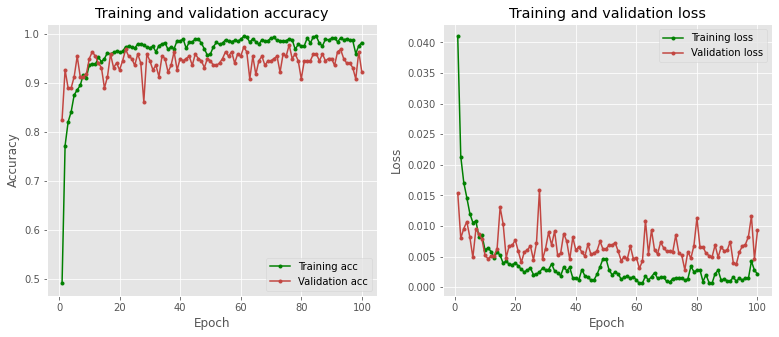

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc',marker = '.',color='#008000')
    plt.plot(x,val_acc, 'r', label='Validation acc',marker = '.',color='#C24641')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',marker = '.',color='#008000')
    plt.plot(x, val_loss, 'r', label='Validation loss',marker = '.',color='#C24641')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('performance_curve.jpg',dpi=600)

plot_history(history.history)

## 95% accuracy

In [ ]:
vgg = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers[:17]:
  layer.trainable = False
for layer in vgg.layers[17:]:
  layer.trainable = True
# do not train first layers, I want to only train
# the 4 last layers (my own choice, up to you)
# vgg.trainable = False

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(128, 128, 3)))
model.add(vgg)
model.add(Flatten())
# finalize with standard Dense, Dropout...
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1)

Epoch 1/100
82/82 [==============================] - 1033s 12s/step - loss: 0.0605 - accuracy: 0.1437 - val_loss: 0.0552 - val_accuracy: 0.1667
Epoch 2/100
82/82 [==============================] - 40s 483ms/step - loss: 0.0542 - accuracy: 0.2397 - val_loss: 0.0495 - val_accuracy: 0.3380
Epoch 3/100
82/82 [==============================] - 39s 480ms/step - loss: 0.0515 - accuracy: 0.2780 - val_loss: 0.0446 - val_accuracy: 0.3704
Epoch 4/100
82/82 [==============================] - 39s 482ms/step - loss: 0.0495 - accuracy: 0.3165 - val_loss: 0.0406 - val_accuracy: 0.4676
Epoch 5/100
82/82 [==============================] - 40s 487ms/step - loss: 0.0503 - accuracy: 0.3237 - val_loss: 0.0354 - val_accuracy: 0.5417
Epoch 6/100
82/82 [==============================] - 39s 481ms/step - loss: 0.0437 - accuracy: 0.4413 - val_loss: 0.0286 - val_accuracy: 0.6111
Epoch 7/100
82/82 [==============================] - 39s 480ms/step - loss: 0.0378 - accuracy: 0.5707 - val_loss: 0.0285 - val_accuracy:

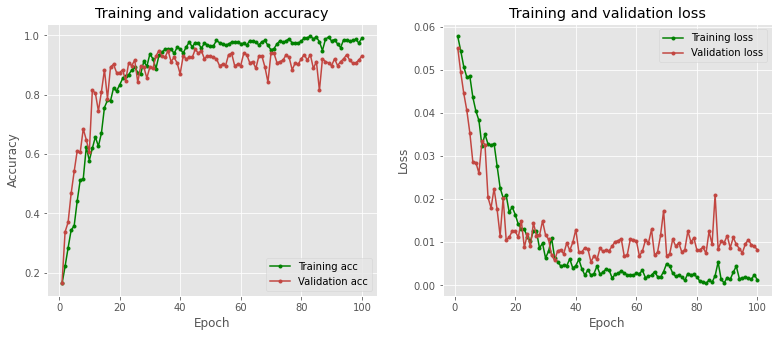

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc',marker = '.',color='#008000')
    plt.plot(x,val_acc, 'r', label='Validation acc',marker = '.',color='#C24641')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',marker = '.',color='#008000')
    plt.plot(x, val_loss, 'r', label='Validation loss',marker = '.',color='#C24641')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('performance_curve.jpg',dpi=600)

plot_history(history.history)

##vgg 16 (accuracy: 93%) : retrain last conv block


In [ ]:
train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.25,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    )

val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(128, 128, 3)))
model.add(vgg)
model.add(Flatten())
# finalize with standard Dense, Dropout...
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1)

Epoch 1/100
82/82 [==============================] - 44s 518ms/step - loss: 0.0621 - accuracy: 0.1429 - val_loss: 0.0457 - val_accuracy: 0.3843
Epoch 2/100
82/82 [==============================] - 41s 498ms/step - loss: 0.0520 - accuracy: 0.2647 - val_loss: 0.0430 - val_accuracy: 0.5093
Epoch 3/100
82/82 [==============================] - 41s 501ms/step - loss: 0.0474 - accuracy: 0.3803 - val_loss: 0.0363 - val_accuracy: 0.5972
Epoch 4/100
82/82 [==============================] - 41s 503ms/step - loss: 0.0451 - accuracy: 0.4614 - val_loss: 0.0364 - val_accuracy: 0.5787
Epoch 5/100
82/82 [==============================] - 40s 489ms/step - loss: 0.0391 - accuracy: 0.4998 - val_loss: 0.0278 - val_accuracy: 0.6898
Epoch 6/100
82/82 [==============================] - 40s 495ms/step - loss: 0.0359 - accuracy: 0.5451 - val_loss: 0.0300 - val_accuracy: 0.6574
Epoch 7/100
82/82 [==============================] - 40s 489ms/step - loss: 0.0327 - accuracy: 0.6001 - val_loss: 0.0244 - val_accuracy:

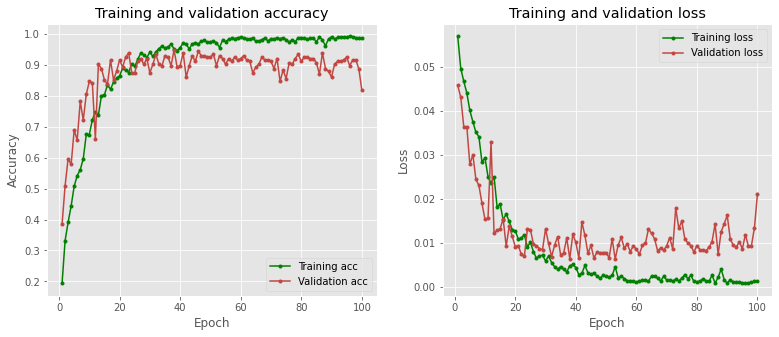

In [ ]:
 import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc',marker = '.',color='#008000')
    plt.plot(x,val_acc, 'r', label='Validation acc',marker = '.',color='#C24641')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',marker = '.',color='#008000')
    plt.plot(x, val_loss, 'r', label='Validation loss',marker = '.',color='#C24641')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('performance_curve.jpg',dpi=600)

plot_history(history.history)

## inception

In [ ]:
# train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     zoom_range=0.25,
#     horizontal_flip=True,
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     # shear_range=0.2
#     )

# val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     )

train_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # zoom_range=0.25,
    # horizontal_flip=True,
    # rotation_range=8,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    )

val_data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )

In [ ]:
train_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/train_noise_and_noise_rot15_flipv/'
train=train_data_aug.flow_from_directory(directory=train_dir,
        target_size=(299, 299),
        batch_size=32,
        color_mode="rgb",
        shuffle=True,
        classes=classes,
        class_mode='categorical')

Found 2619 images belonging to 7 classes.


In [ ]:
valid_dir='/content/drive/MyDrive/Traditional Food Classification/set 1/validation'
valid=val_data_aug.flow_from_directory(directory=valid_dir,
        # target_size=(299, 299),
        target_size=(224, 224),
        batch_size=36,
        color_mode="rgb",
        shuffle=False,
        classes=classes,
        class_mode='categorical')

Found 216 images belonging to 7 classes.


In [ ]:
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications import Xception

In [ ]:
incpt = InceptionV3(
    include_top=False,
    weights='imagenet',
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
incpt.trainable=False

In [ ]:
incpt.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(299, 299, 3)))
model.add(incpt)
model.add(Flatten())
# finalize with standard Dense, Dropout...
# model.add(Dense(256, activation='relu'))
# # model.add(BatchNormalization())
# model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_94 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 7)                 917511    
Total params: 22,728,499
Trainable params: 921,613
Non-trainable params: 21,806,886
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

model.compile(loss='logcosh',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1)

Epoch 1/100
82/82 [==============================] - 918s 11s/step - loss: 0.0659 - accuracy: 0.3080 - val_loss: 0.0498 - val_accuracy: 0.5278
Epoch 2/100
82/82 [==============================] - 41s 498ms/step - loss: 0.0474 - accuracy: 0.5281 - val_loss: 0.0335 - val_accuracy: 0.6713
Epoch 3/100
82/82 [==============================] - 41s 497ms/step - loss: 0.0351 - accuracy: 0.6580 - val_loss: 0.0345 - val_accuracy: 0.6759
Epoch 4/100
82/82 [==============================] - 41s 497ms/step - loss: 0.0317 - accuracy: 0.6826 - val_loss: 0.0337 - val_accuracy: 0.6806
Epoch 5/100
82/82 [==============================] - 41s 499ms/step - loss: 0.0319 - accuracy: 0.6885 - val_loss: 0.0319 - val_accuracy: 0.6713
Epoch 6/100
82/82 [==============================] - 41s 502ms/step - loss: 0.0281 - accuracy: 0.7217 - val_loss: 0.0322 - val_accuracy: 0.6713
Epoch 7/100
82/82 [==============================] - 41s 500ms/step - loss: 0.0286 - accuracy: 0.7152 - val_loss: 0.0322 - val_accuracy: 

In [ ]:
history = model.fit(train,validation_data=valid,shuffle=True,epochs=100,verbose=1)


Epoch 1/100
82/82 [==============================] - 94s 1s/step - loss: 2.3091 - accuracy: 0.3638 - val_loss: 0.5929 - val_accuracy: 0.7685
Epoch 2/100
82/82 [==============================] - 83s 1s/step - loss: 0.9850 - accuracy: 0.6688 - val_loss: 0.4867 - val_accuracy: 0.8148
Epoch 3/100
82/82 [==============================] - 82s 1s/step - loss: 0.8420 - accuracy: 0.7094 - val_loss: 0.5066 - val_accuracy: 0.8194
Epoch 4/100
82/82 [==============================] - 82s 998ms/step - loss: 0.7592 - accuracy: 0.7509 - val_loss: 0.3208 - val_accuracy: 0.8935
Epoch 5/100
82/82 [==============================] - 82s 994ms/step - loss: 0.8184 - accuracy: 0.7502 - val_loss: 0.3670 - val_accuracy: 0.8704
Epoch 6/100
82/82 [==============================] - 82s 999ms/step - loss: 0.7414 - accuracy: 0.7735 - val_loss: 0.2856 - val_accuracy: 0.9028
Epoch 7/100
82/82 [==============================] - 82s 995ms/step - loss: 0.6696 - accuracy: 0.7800 - val_loss: 0.2624 - val_accuracy: 0.8935
E

In [ ]:
max(history.history['val_accuracy']) 

0.9583333134651184

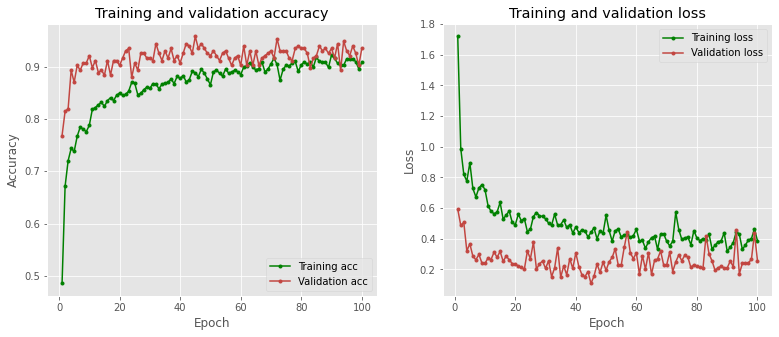

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc',marker = '.',color='#008000')
    plt.plot(x,val_acc, 'r', label='Validation acc',marker = '.',color='#C24641')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',marker = '.',color='#008000')
    plt.plot(x, val_loss, 'r', label='Validation loss',marker = '.',color='#C24641')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('performance_curve.jpg',dpi=600)

plot_history(history.history)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Traditional Food Classification/set 1/history_incpt', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [ ]:
model_json =model.to_json()
with open("/content/drive/MyDrive/Traditional Food Classification/set 1/incpt.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Traditional Food Classification/set 1/incpt.h5")
print("Saved model to disk")

Saved model to disk
